In [8]:
import pandas as pd
import numpy as np
import torch 
from fredapi import Fred

In [677]:
batch_size = 4
seq_length = 10

In [487]:
with open("fred_key.txt", 'r') as f:
    key = f.read()


fred = Fred(api_key=key)

data_dict = {
    "CPIAUCSL": "CPI",
    "UNRATE": "Unemployment",
    "FEDFUNDS": "fed_rate"
}

def get_data(data_dict):
    data = {data_dict[code]: fred.get_series_latest_release(code) for code in data_dict}
    df = pd.DataFrame(data)
    return df

data = get_data(data_dict)
print(data.shape)
data.tail()

(926, 3)


,CPI,Unemployment,fed_rate
2023-10-01,307.531,3.8,5.33
2023-11-01,308.024,3.7,5.33
2023-12-01,308.742,3.7,5.33
2024-01-01,309.685,3.7,5.33
2024-02-01,311.054,3.9,5.33


In [23]:
def difference_data(df):
    df['log_inflation_MoM'] =  np.log(df["CPI"]).diff()
    df['fed_rate_DIFF'] = np.log(df["fed_rate"]).diff()
    df['Unemployment_DIFF'] = df["Unemployment"].diff()
    return df.dropna()

data_diff = difference_data(data)
print(data_diff.tail())

                CPI  Unemployment  fed_rate  log_inflation_MoM  fed_rate_DIFF  \
2023-10-01  307.531           3.8      5.33           0.000790            0.0   
2023-11-01  308.024           3.7      5.33           0.001602            0.0   
2023-12-01  308.742           3.7      5.33           0.002328            0.0   
2024-01-01  309.685           3.7      5.33           0.003050            0.0   
2024-02-01  311.054           3.9      5.33           0.004411            0.0   

            Unemployment_DIFF  
2023-10-01                0.0  
2023-11-01               -0.1  
2023-12-01                0.0  
2024-01-01                0.0  
2024-02-01                0.2  


<Axes: >

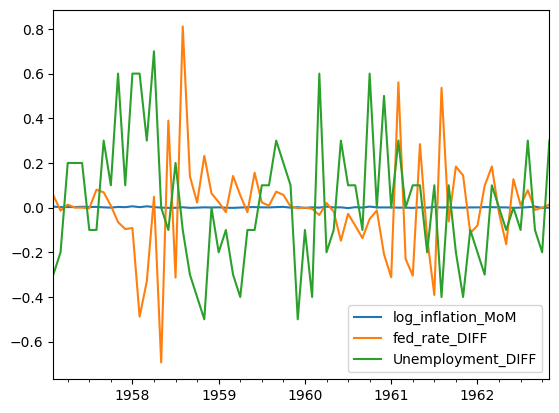

In [410]:
data_diff[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]].iloc[30:100].plot()

<Axes: >

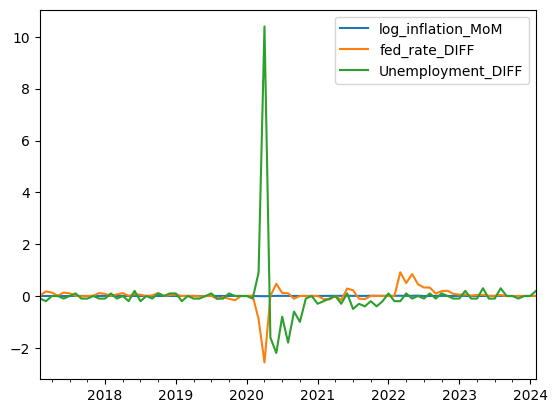

In [600]:
data_diff[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]].iloc[750:].plot()

In [605]:
data_diff.loc["2020-03-01"]

CPI                  258.150000
Unemployment           4.400000
fed_rate               0.650000
log_inflation_MoM     -0.004237
fed_rate_DIFF         -0.888208
Unemployment_DIFF      0.900000
Name: 2020-03-01 00:00:00, dtype: float64

In [529]:
cutoff = int(data_diff.shape[0]*0.75)
print(cutoff)
data_diff.iloc[cutoff-1]

626


CPI                  202.800000
Unemployment           4.500000
fed_rate               5.250000
log_inflation_MoM     -0.004919
fed_rate_DIFF          0.000000
Unemployment_DIFF     -0.200000
Name: 2006-09-01 00:00:00, dtype: float64

In [678]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

class MonetaryPolicyDataSet(torch.utils.data.Dataset):
    def __init__(self, train=True, train_end_year=None, seq_length=3):
        self.seq_length = seq_length
        
        self.data_dict = {
            "CPIAUCSL": "CPI",
            "UNRATE": "Unemployment",
            "FEDFUNDS": "fed_rate"
        }
        
        
        
        data = get_data(self.data_dict)
        self.data = difference_data(data)[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]]
        self.data = self.data[self.data.index != "2020-04-01"]
        
        if train:
            self.data = self.data.loc[:train_end_year]
            scaler.fit(self.data)
        else:
            # Create test set after the train_end_year
            self.data = self.data.loc[pd.to_datetime(train_end_year) + pd.DateOffset(months=1):]
        
        self.data = scaler.transform(self.data)
        # Convert to pytorch tensor
        self.data = torch.tensor(self.data)
        
        
    def __getitem__(self, t):
        return self.data[t: t + self.seq_length], self.data[t + self.seq_length]
    
    
    def __len__(self):
        return len(self.data) - self.seq_length

In [679]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


train_dataset = MonetaryPolicyDataSet(train=True, train_end_year="2006-09-01", seq_length = seq_length)
test_dataset = MonetaryPolicyDataSet(train=False, train_end_year="2006-09-01", seq_length = seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

batch_id, (x, y) = next(enumerate(train_dataloader))
print(x, y)
print(x.size())

tensor([[[-1.1938,  4.2889,  1.0671],
         [-1.5645, -1.3737,  0.5391],
         [-2.1849, -2.3870, -2.1014],
         [-0.3269, -0.2745, -2.1014],
         [-1.1942,  4.4035, -1.5733],
         [-1.0704,  0.8132, -0.5171],
         [-0.4519, -0.7950, -1.0452],
         [-1.4413,  0.4346, -0.5171],
         [-1.0704,  0.5585,  0.5391],
         [-1.3179, -0.0308, -2.1014]],

        [[-1.5645, -1.3737,  0.5391],
         [-2.1849, -2.3870, -2.1014],
         [-0.3269, -0.2745, -2.1014],
         [-1.1942,  4.4035, -1.5733],
         [-1.0704,  0.8132, -0.5171],
         [-0.4519, -0.7950, -1.0452],
         [-1.4413,  0.4346, -0.5171],
         [-1.0704,  0.5585,  0.5391],
         [-1.3179, -0.0308, -2.1014],
         [-1.8141,  1.3718, -0.5171]],

        [[-2.1849, -2.3870, -2.1014],
         [-0.3269, -0.2745, -2.1014],
         [-1.1942,  4.4035, -1.5733],
         [-1.0704,  0.8132, -0.5171],
         [-0.4519, -0.7950, -1.0452],
         [-1.4413,  0.4346, -0.5171],
        

In [254]:
batch_id, (x, y) = next(enumerate(test_dataloader))
print(x)

tensor([[[-0.0044,  0.0000, -0.1000],
         [ 0.0005,  0.0000,  0.1000],
         [ 0.0054, -0.0019, -0.1000]],

        [[ 0.0005,  0.0000,  0.1000],
         [ 0.0054, -0.0019, -0.1000],
         [ 0.0017,  0.0019,  0.2000]],

        [[ 0.0054, -0.0019, -0.1000],
         [ 0.0017,  0.0019,  0.2000],
         [ 0.0039,  0.0019, -0.1000]],

        [[ 0.0017,  0.0019,  0.2000],
         [ 0.0039,  0.0019, -0.1000],
         [ 0.0052,  0.0000, -0.1000]]], dtype=torch.float64)


In [585]:
import torch.functional as F
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        
        self.recurrent_layer = torch.nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first = True,
            bidirectional = False
        )
        
        self.fc1 = torch.nn.Linear(hidden_size, 1, bias=True)        
        
    def forward(self, x):
        x, hidden = self.recurrent_layer(x)
        x = self.fc1(x)
        return x
        

## Test forward

In [680]:
scaled_data = scaler.transform(data_diff[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]])
scaled_data_df = pd.DataFrame(scaled_data, columns = ["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"])
scaled_data_df = scaled_data_df[scaled_data_df != "2020-04-01"]
scaled_data_df.head()

,log_inflation_MoM,fed_rate_DIFF,Unemployment_DIFF
0,-1.193801,4.288944,1.067140
1,-1.564529,-1.373702,0.539053
2,-2.184919,-2.386957,-2.101380
3,-0.326935,-0.274500,-2.101380
4,-1.194170,4.403543,-1.573293


In [513]:
# Test forward pass
model = RNNModel(seq_length, 20)

test_input = x[0:2].float().transpose(1,2)
print("Input:")
print(test_input.float())

with torch.no_grad():
    print("Output: ")
    print(model(test_input).reshape(-1, 3))
    print(y[0:2].float())

Input:
tensor([[[-1.1938],
         [ 4.2889],
         [ 1.0671]],

        [[-1.5645],
         [-1.3737],
         [ 0.5391]]])
Output: 
tensor([[ 0.1837, -0.2158,  0.0462],
        [ 0.2038,  0.1314,  0.0054]])
tensor([[-1.5645, -1.3737,  0.5391],
        [-2.1849, -2.3870, -2.1014]])


In [324]:
mse = nn.MSELoss()
mse(model(test_input).reshape(-1, 3), y[0:2])

tensor(0.0882, dtype=torch.float64, grad_fn=<MseLossBackward0>)

## Train RNN

In [681]:
from torch import optim
import torch.nn as nn
random_seed = 1
torch.manual_seed(random_seed)
log_interval = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNN:
    def __init__(self,
                 n_epoch:int,
                 train_loader,
                 validation_loader):

        self.n_epoch = n_epoch

        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.net = RNNModel(seq_length, 20)
        self.net.to(device)
        
        self.optimizer = optim.Adam(
            lr=0.0001, 
            params=self.net.parameters()
        ) 
        
        self.loss = nn.MSELoss()


        
    def train(self):
        self.epoch_error = []
        self.val_error = []
        for epoch in range(1, self.n_epoch + 1):
            error = self.train_loop(epoch)
            self.epoch_error.append(error)
            val_error =self.validation()
            self.val_error.append(val_error)
            
            if epoch % 10 == 0:
                print("epoch error", error)
                print('total_val_error:', val_error)
        
        
    def train_loop(self, epoch):
        losses = []
        for idx, (x, y) in enumerate(self.train_loader):
            
            x = x.to(device).float().transpose(1,2)
            y = y.to(device).float()
            self.optimizer.zero_grad()

            output = self.net(x).reshape(-1,3)
            loss = self.loss(output, y)
            losses.append(loss.item())
            loss.backward()

            self.optimizer.step()

            if idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(x), len(self.train_loader.dataset),
                100. * idx / len(self.train_loader), loss.item()))


        return np.mean(losses)

    
    def validation(self):
        val_loss_list = []
        for idx, (x, y) in enumerate(self.validation_loader):
            x = x.to(device).float().transpose(1,2)
            y = y.to(device).float()
            with torch.no_grad():
                validation_output = self.net(x).reshape(-1,3)
                loss_val = self.loss(validation_output, y)
                val_loss_list.append(loss_val.item())
                #print("predicted:", vfunc(chars), "target:", vfunc(y_pos))
                if idx % log_interval==0:
                    print("Validation_loss: {:.6f}".format(loss_val.item()))
                    
        return np.mean(val_loss_list)

    
    def predict(self, x):
        with torch.no_grad():
            try:
                pred = self.net(x.to(device).float().transpose(1,2)).reshape((-1, 3))
            except Exception:
                pred = self.net(x.to(device).float()).reshape((-1, 3))
                return pred
            else:
                return pred
        


rnn = RNN(50, train_dataloader, test_dataloader)
rnn.train()

Train Epoch: 1 [0/616 (0%)]	Loss: 1.059069
Train Epoch: 1 [400/616 (65%)]	Loss: 0.093972
Validation_loss: 0.437781
Train Epoch: 2 [0/616 (0%)]	Loss: 0.991871
Train Epoch: 2 [400/616 (65%)]	Loss: 0.090440
Validation_loss: 0.435803
Train Epoch: 3 [0/616 (0%)]	Loss: 0.944431
Train Epoch: 3 [400/616 (65%)]	Loss: 0.087946
Validation_loss: 0.433954
Train Epoch: 4 [0/616 (0%)]	Loss: 0.911162
Train Epoch: 4 [400/616 (65%)]	Loss: 0.086214
Validation_loss: 0.432178
Train Epoch: 5 [0/616 (0%)]	Loss: 0.888385
Train Epoch: 5 [400/616 (65%)]	Loss: 0.085014
Validation_loss: 0.430447
Train Epoch: 6 [0/616 (0%)]	Loss: 0.872922
Train Epoch: 6 [400/616 (65%)]	Loss: 0.084185
Validation_loss: 0.428751
Train Epoch: 7 [0/616 (0%)]	Loss: 0.862450
Train Epoch: 7 [400/616 (65%)]	Loss: 0.083619
Validation_loss: 0.427091
Train Epoch: 8 [0/616 (0%)]	Loss: 0.855351
Train Epoch: 8 [400/616 (65%)]	Loss: 0.083241
Validation_loss: 0.425473
Train Epoch: 9 [0/616 (0%)]	Loss: 0.850527
Train Epoch: 9 [400/616 (65%)]	Loss: 

### Note that the validation error will probably be way larger due to the covid shock

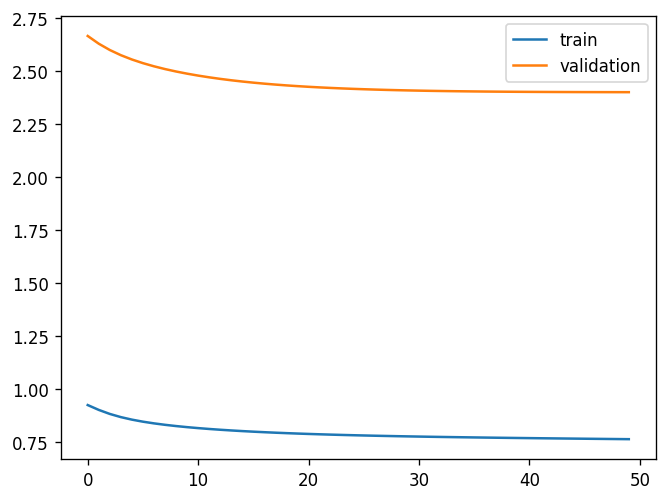

In [682]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)

ax.plot(np.arange(len(rnn.epoch_error)), rnn.epoch_error, label='train')
ax.plot(np.arange(len(rnn.val_error)), rnn.val_error, label='validation')
plt.legend()

## Look at some of the fitted values

In [683]:
means = scaler.mean_
standard_devs = np.sqrt(scaler.var_)

In [696]:
def get_predictions(loader, return_residuals = False):
    mse = nn.MSELoss(reduction="none")
    predictions = []
    residuals = []
    for idx, (x, y) in enumerate(loader):
        pred = rnn.predict(x)
        predictions.append(pred)
        
        res = pred-y.to(device)
        residuals.append(res)
        
    predictions_concat = torch.concat(predictions, dim=0).cpu().numpy()
    residuals_concat = torch.concat(residuals, dim=0).cpu().numpy()
    if return_residuals:
        return predictions_concat, residuals_concat
    else:
        return predictions_concat

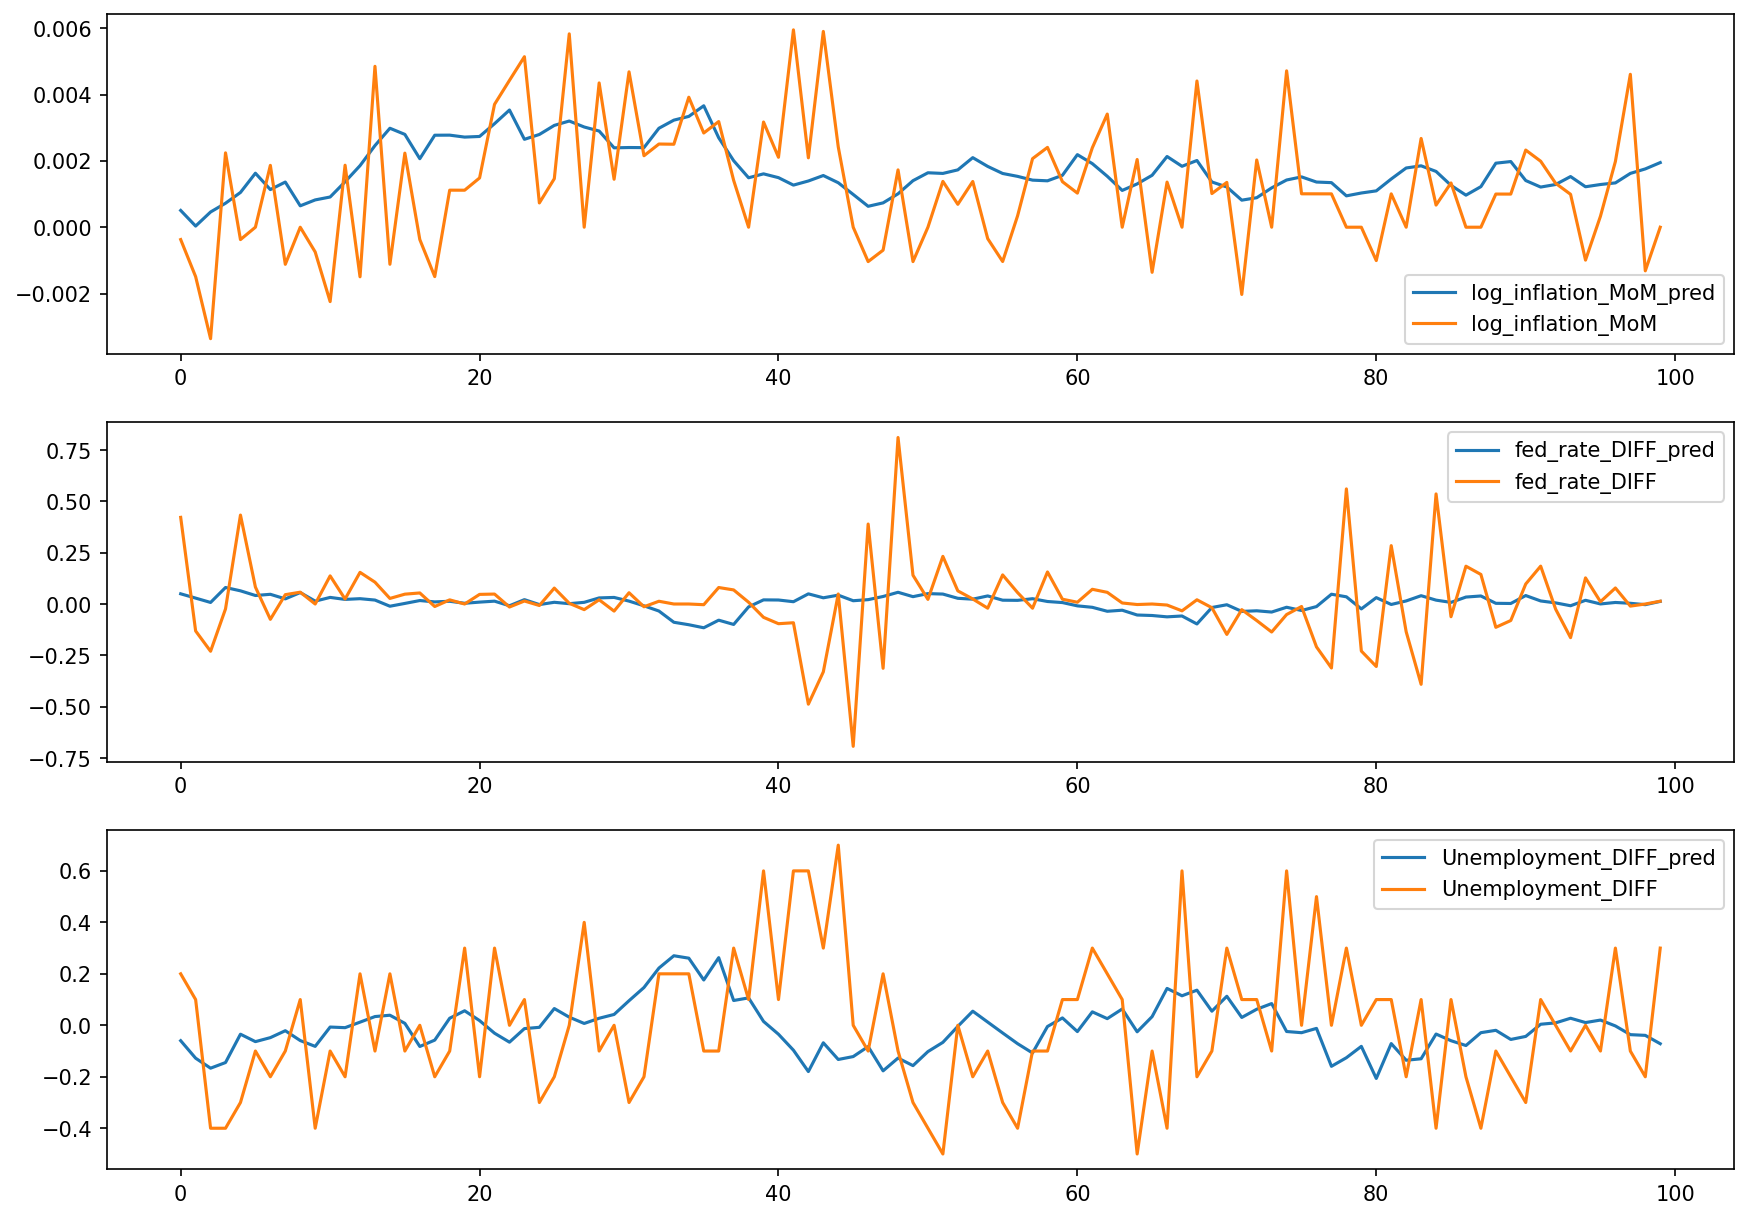

In [685]:

def plot_predictions(range_:list, loader, test=False):
    predictions = get_predictions(loader)

    # If we are testing we need to start the index at the cutoff for when we concatinate predictions 
    # with the actual values
    predictions_index = None if not test else np.arange(cutoff+seq_length+1, scaled_data_df.shape[0])

    predictions_df = pd.DataFrame(
        predictions, 
        columns = ["log_inflation_MoM_pred", "fed_rate_DIFF_pred", "Unemployment_DIFF_pred"], 
        index=predictions_index
    )

    fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))
    all_data=pd.concat([scaled_data_df, predictions_df], ignore_index=False, axis=1)


    (all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]]*standard_devs[0] + means[0]).iloc[range_[0]:range_[1]].plot(ax=axs[0])
    (all_data[["fed_rate_DIFF_pred", "fed_rate_DIFF"]]*standard_devs[1] + means[1]).iloc[range_[0]:range_[1]].plot(ax=axs[1])
    (all_data[["Unemployment_DIFF_pred", "Unemployment_DIFF"]]*standard_devs[2] + means[2]).iloc[range_[0]:range_[1]].plot(ax=axs[2])

plot_predictions([0, 100], train_dataloader)

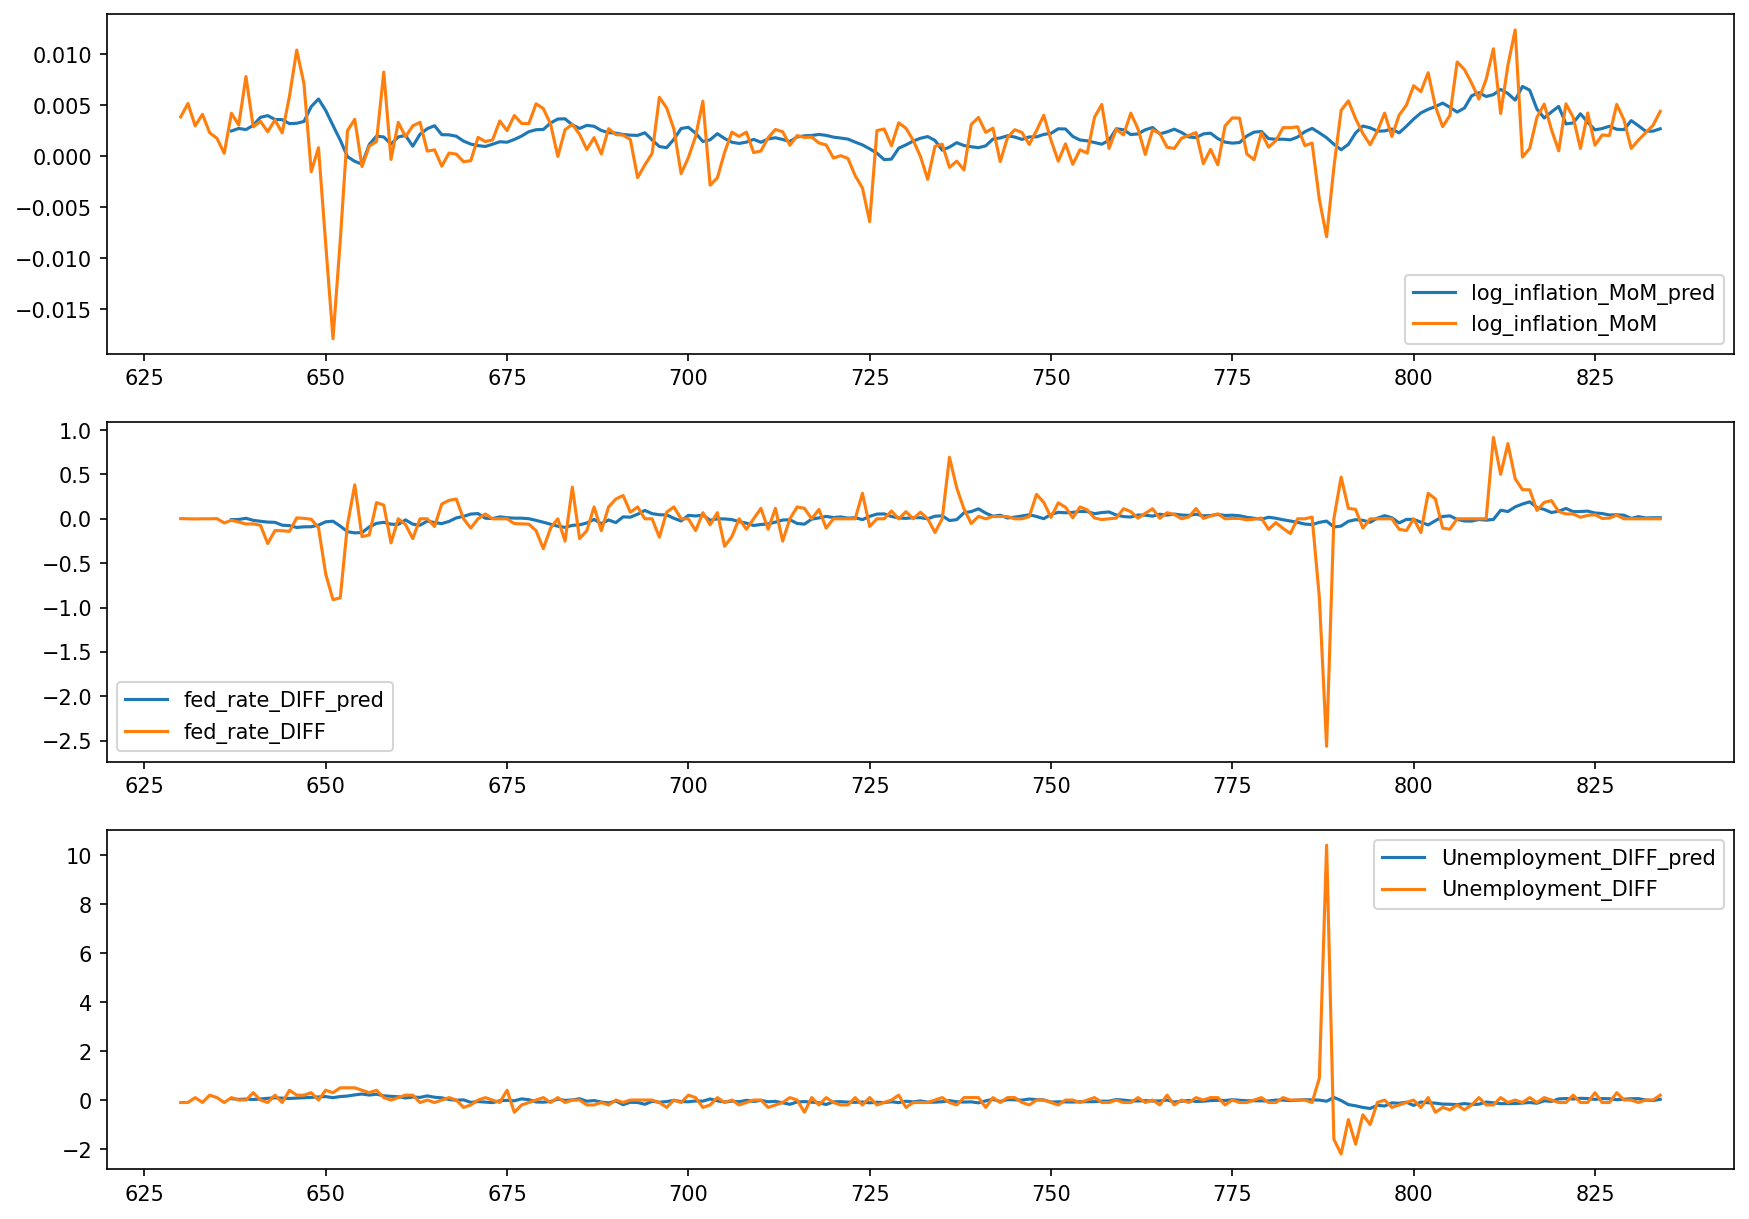

In [686]:
plot_predictions([630, data_diff.shape[0]], test_dataloader, test=True)

## Check that residuals are white noise

Text(0.5, 1.0, 'Unemployment_DIFF_pred Residuals')

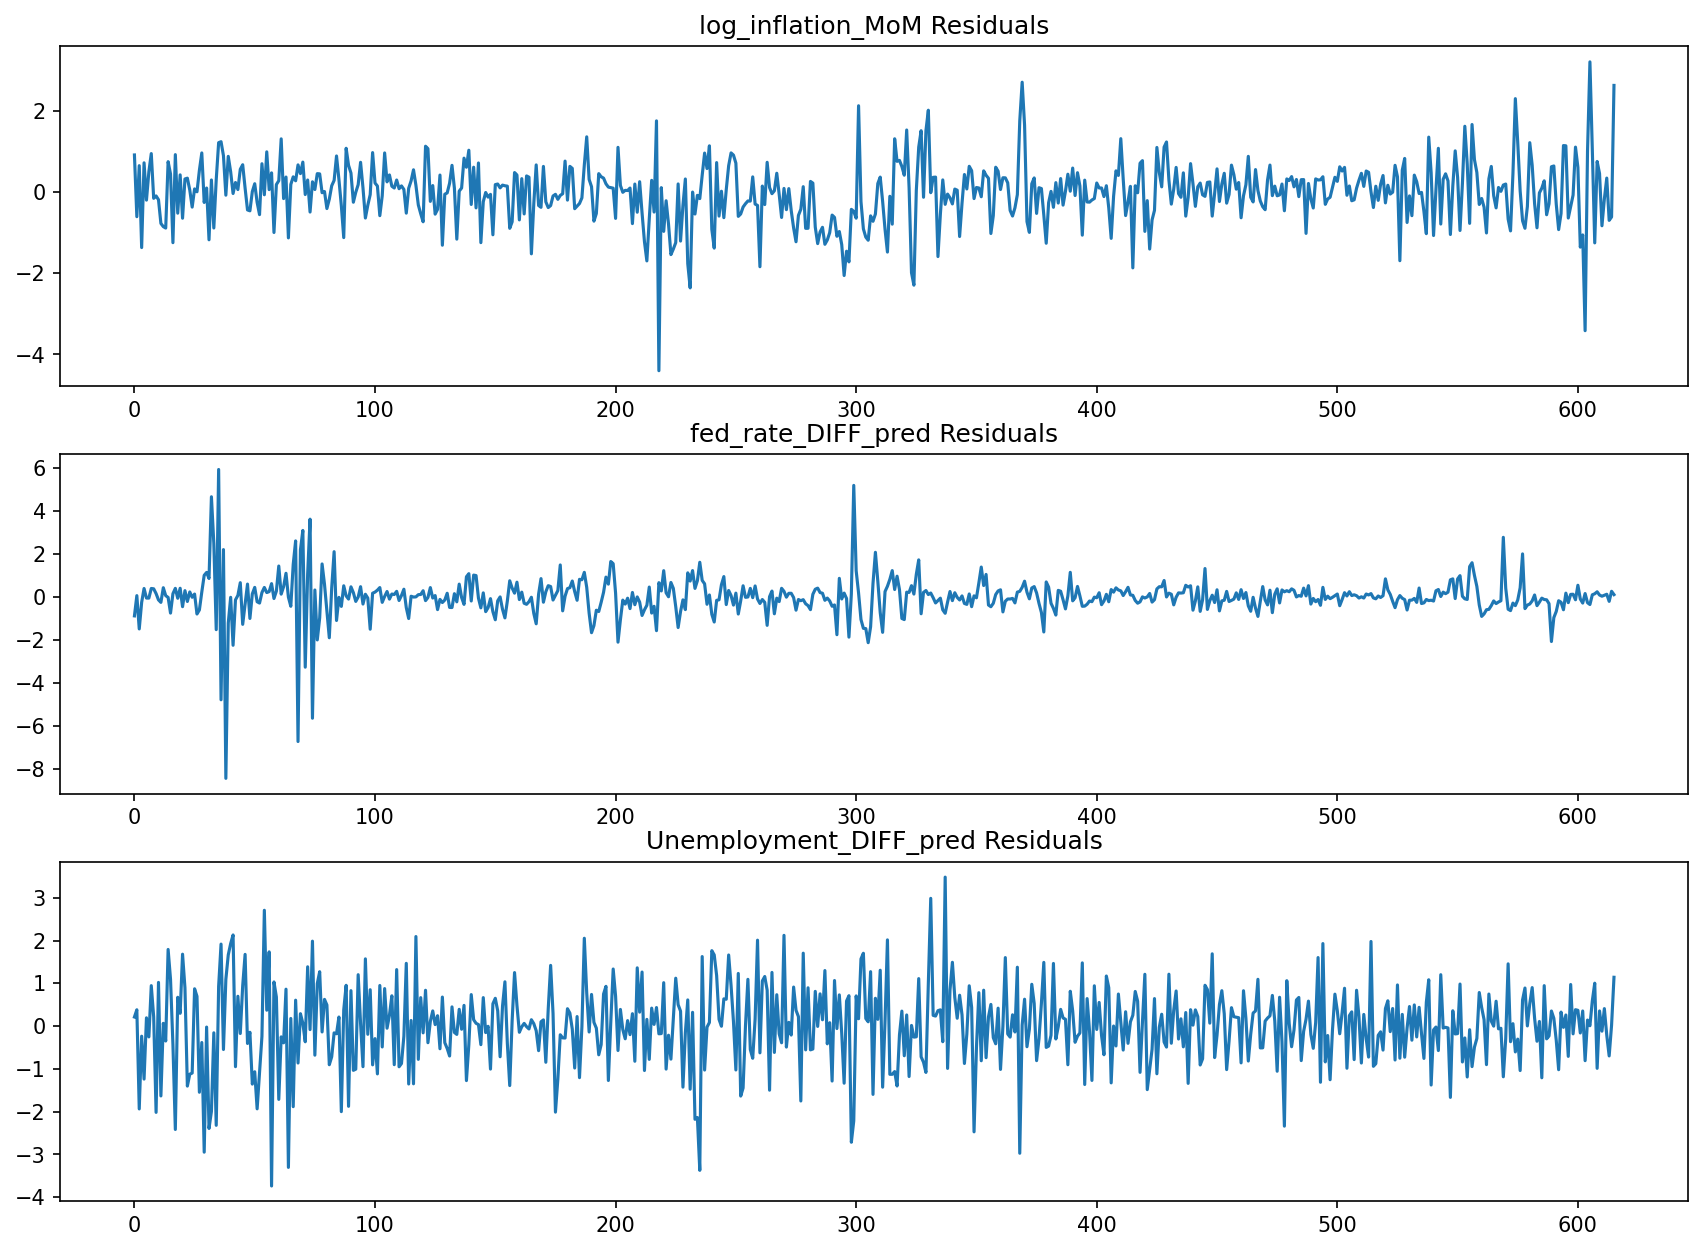

In [706]:
pred, res = get_predictions(train_dataloader,return_residuals=True)
residuals_df = pd.DataFrame(
        res, 
        columns = ["log_inflation_MoM_pred_res", "fed_rate_DIFF_pred_res", "Unemployment_DIFF_pred_res"]
    )

fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))

residuals_df["log_inflation_MoM_pred_res"].plot(ax=axs[0])
residuals_df["fed_rate_DIFF_pred_res"].plot(ax=axs[1])
residuals_df["Unemployment_DIFF_pred_res"].plot(ax=axs[2])
axs[0].set_title("log_inflation_MoM Residuals")
axs[1].set_title("fed_rate_DIFF_pred Residuals")
axs[2].set_title("Unemployment_DIFF_pred Residuals")